In [1]:
from __future__ import division

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
import xgboost as xgb
from xgboost.sklearn import XGBClassifier #this is the SKlearn wrapper
from sklearn import neighbors, linear_model
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import roc_curve, auc

import scipy.io as sio

/Users/luca/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
Healthy = pd.read_csv('./Data/Healthy1.csv',header=None)
Amp = pd.read_csv('./Data/Amp1.csv',header=None)

In [3]:
Healthy = Healthy.rename(index=int, columns={0:'SubjID',1:'Loc',2:'Subjtype',3:'Falltype'})
Amp = Amp.rename(index=int, columns={0:'SubjID',1:'Loc',2:'Subjtype',3:'Falltype'})

In [4]:
#Subjtype: 0 = Amputee, 1 = Healthy , 2 = Healthy outdoor
Healthy.head(5)

,SubjID,Loc,Subjtype,Falltype,4,5,6,7,8,9,...,1205,1206,1207,1208,1209,1210,1211,1212,1213,1214
0,1,1,1,3,0.132230,0.074660,-0.11889,0.012579,0.049360,0.051680,...,2.2354,4.9977,0.72193,0.78766,0.053909,0.085895,0.071485,0.090722,0.046334,0.127110
1,1,1,1,3,-0.077828,0.070436,-0.21730,-0.028075,0.042425,0.076308,...,2.2354,4.9974,0.72193,0.80493,0.055249,0.092283,0.096109,0.103440,0.095055,0.080526
2,1,1,1,3,-0.006114,0.034498,-0.20617,-0.025551,0.034052,0.071821,...,2.2313,4.9824,1.37100,0.81752,0.055180,0.096682,0.093441,0.077564,0.101470,0.067335
3,1,1,1,4,-0.154480,0.024149,0.31641,-0.031890,0.042762,0.069643,...,2.2358,4.9990,0.72193,0.51662,0.039205,0.099017,0.071918,0.094359,0.072023,0.086206
4,1,1,1,4,-0.163620,0.023899,0.32266,-0.042376,0.007777,0.056139,...,2.2360,4.9997,0.72193,0.68568,0.048051,0.093172,0.083448,0.118910,0.063367,0.049815


In [5]:
print len(Healthy)
print len(Amp)

948
495


In [9]:
print ('N subjects Healthy: %s'%(len(Healthy.SubjID.unique())))
print ('N subjects Amp: %s'%(len(Amp.SubjID.unique())))
print Healthy.Subjtype.unique()
print Amp.Subjtype.unique()

N subjects Healthy: 10
N subjects Amp: 7
[1 2]
[0]


In [10]:
#Healthy
print ('Nfalls = %s')%(len(Healthy[Healthy.Falltype<9]))
print ('Nactivities = %s')%(len(Healthy[Healthy.Falltype==9]))

Nfalls = 633
Nactivities = 315


In [11]:
#Amp
print ('Nfalls = %s')%(len(Amp[Amp.Falltype<9]))
print ('Nactivities = %s')%(len(Amp[Amp.Falltype==9]))

Nfalls = 188
Nactivities = 307


In [12]:
#selecting cols by index
Healthy.iloc[1:5, 0:4]

,SubjID,Loc,Subjtype,Falltype
1,1,1,1,3
2,1,1,1,3
3,1,1,1,4
4,1,1,1,4


### Train on healthy and test on amputees

In [13]:
#transform to binary class
Xtr = Healthy.iloc[:,4:].as_matrix()
ytr = Healthy.Falltype.as_matrix()
Xte = Amp.iloc[:,4:].as_matrix()
yte = Amp.Falltype.as_matrix()
ytr[ytr < 9] = 1
ytr[ytr == 9] = 0
yte[yte < 9] = 1
yte[yte == 9] = 0

In [14]:
print Xtr.shape
print np.unique(ytr)
print Xte.shape
print np.unique(yte)

(948, 1211)
[0 1]
(495, 1211)
[0 1]


In [15]:
forest = RandomForestClassifier(n_estimators=50,random_state=10)
forest.fit(Xtr,ytr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=10,
            verbose=0, warm_start=False)

In [16]:
importance = forest.feature_importances_
print(importance)
indices = np.argsort(importance)
importance_std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
print(importance_std)

[ 0.          0.00019033  0.00010712 ...,  0.00016624  0.00025722  0.        ]
[ 0.          0.00093251  0.00067254 ...,  0.00116369  0.00180052  0.        ]


In [17]:
importance_norm = importance/np.max(importance)

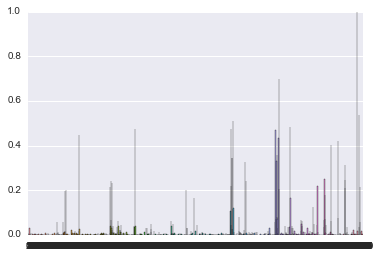

In [18]:
#using Seaborn
ax = sns.barplot(x=indices,y=importance_norm[indices])
sns.set_context("paper")
plt.figure(figsize=(8,6))

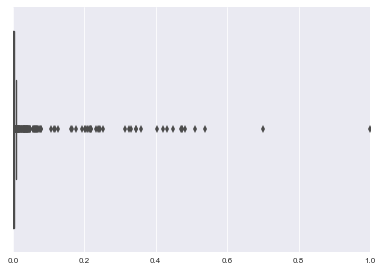

In [19]:
ax = sns.boxplot(importance_norm)
plt.figure(figsize=(8,6))

In [20]:
qc = np.percentile(importance_norm,[75])
print 1.5*qc

[ 0.00468037]


In [21]:
#indmax = np.argwhere(importance_norm >= 1.5*qc)
indmax = np.argwhere(importance_norm >= 0.1)
indmax = indmax.reshape(-1)
print len(indmax)
print indmax

39
[ 134  137  184  294  300  302  387  569  599  731  732  734  737  738  739
  740  742  785  786  894  898  900  905  906  907  946  948 1031 1046 1071
 1072 1095 1121 1144 1145 1146 1190 1195 1200]


In [22]:
forest = RandomForestClassifier(n_estimators=50,random_state=10,warm_start=False)
forest.fit(Xtr[:,indmax],ytr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=10,
            verbose=0, warm_start=False)

In [23]:
ypred = forest.predict(Xte[:,indmax])
yscore = forest.predict_proba(Xte[:,indmax])
yscore = yscore[:,1]

In [24]:
acc = np.sum(ypred==yte)/len(ypred)
print('Acc = %.3f')%acc
fpr, tpr, thresholds = metrics.roc_curve(yte, yscore, pos_label=1)
roc_auc = auc(fpr, tpr)
print('AUC = %.3f'%roc_auc)

Acc = 0.982
AUC = 0.997


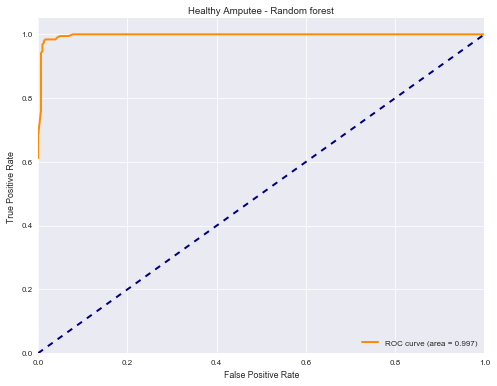

In [27]:
plt.figure(figsize=(8,6))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Healthy Amputee - Random forest')
plt.legend(loc="lower right")

In [ ]:
glmnetCV = ElasticNetCV(l1_ratio=[.1,.5,.7,.9,.95,.99,1],cv=5,random_state=10,verbose=1,normalize=False)
glmnetCV.fit(Xtr,ytr)

## CV on Healthy

In [28]:
from sklearn.model_selection import LeaveOneGroupOut

In [29]:
Healthy = pd.read_csv('./Data/Healthy1.csv',header=None)
Amp = pd.read_csv('./Data/Amp1.csv',header=None)
Healthy = Healthy.rename(index=int, columns={0:'SubjID',1:'Loc',2:'Subjtype',3:'Falltype'})
Amp = Amp.rename(index=int, columns={0:'SubjID',1:'Loc',2:'Subjtype',3:'Falltype'})

In [30]:
#indoor falls 
print np.sort(Healthy[Healthy.Subjtype == 1].SubjID.unique())
print np.sort(Healthy[Healthy.Subjtype == 2].SubjID.unique())

[ 1  2  3  4  5  6  7  8  9 10]
[ 1  2  4  5  6  7  8  9 10]


In [31]:
#train on indoor test on outdoor
#Subjtype: 0 = Amputee, 1 = Healthy , 2 = Healthy outdoor
Xin = Healthy[Healthy.Subjtype == 1]
Xout = Healthy[Healthy.Subjtype == 2]

In [32]:
Xin.head(5)

,SubjID,Loc,Subjtype,Falltype,4,5,6,7,8,9,...,1205,1206,1207,1208,1209,1210,1211,1212,1213,1214
0,1,1,1,3,0.132230,0.074660,-0.11889,0.012579,0.049360,0.051680,...,2.2354,4.9977,0.72193,0.78766,0.053909,0.085895,0.071485,0.090722,0.046334,0.127110
1,1,1,1,3,-0.077828,0.070436,-0.21730,-0.028075,0.042425,0.076308,...,2.2354,4.9974,0.72193,0.80493,0.055249,0.092283,0.096109,0.103440,0.095055,0.080526
2,1,1,1,3,-0.006114,0.034498,-0.20617,-0.025551,0.034052,0.071821,...,2.2313,4.9824,1.37100,0.81752,0.055180,0.096682,0.093441,0.077564,0.101470,0.067335
3,1,1,1,4,-0.154480,0.024149,0.31641,-0.031890,0.042762,0.069643,...,2.2358,4.9990,0.72193,0.51662,0.039205,0.099017,0.071918,0.094359,0.072023,0.086206
4,1,1,1,4,-0.163620,0.023899,0.32266,-0.042376,0.007777,0.056139,...,2.2360,4.9997,0.72193,0.68568,0.048051,0.093172,0.083448,0.118910,0.063367,0.049815


In [33]:
print(len(Xin))
print(len(Xout))
print(np.sort(Xin.Falltype.unique()))
print(np.sort(Xout.Falltype.unique()))

653
295
[1 2 3 4 9]
[1 2 3 4]


In [34]:
#LOSO on indoor
X = Xin.iloc[:,4:].as_matrix()
y = Xin.Falltype.as_matrix()
y[y < 9] = 1
y[y == 9] = 0

In [35]:
print X.shape
print y.shape

(653, 1211)
(653,)


In [36]:
groups = Xin.SubjID.as_matrix()
print groups.shape
print np.unique(groups)

(653,)
[ 1  2  3  4  5  6  7  8  9 10]


In [37]:
subj = LeaveOneGroupOut()
subj.get_n_splits(X,y,groups)

10

In [38]:
X.shape

(653, 1211)

In [39]:
indmax #602 gyro features + 602 accelerometer

array([ 134,  137,  184,  294,  300,  302,  387,  569,  599,  731,  732,
        734,  737,  738,  739,  740,  742,  785,  786,  894,  898,  900,
        905,  906,  907,  946,  948, 1031, 1046, 1071, 1072, 1095, 1121,
       1144, 1145, 1146, 1190, 1195, 1200])

In [40]:
for train_index, test_index in subj.split(X, y, groups):
    Xtr = X[train_index]
    Xtr = Xtr[:,indmax]
    print Xtr.shape

(595, 39)
(605, 39)
(570, 39)
(603, 39)
(605, 39)
(583, 39)
(594, 39)
(596, 39)
(544, 39)
(582, 39)


In [41]:
print X.shape
print y.shape

(653, 1211)
(653,)


AUC = 1.0000
AUC = 1.0000
AUC = 0.9935
AUC = 1.0000
AUC = 1.0000
AUC = 1.0000
AUC = 1.0000
AUC = 1.0000
AUC = 0.9819
AUC = 0.9976


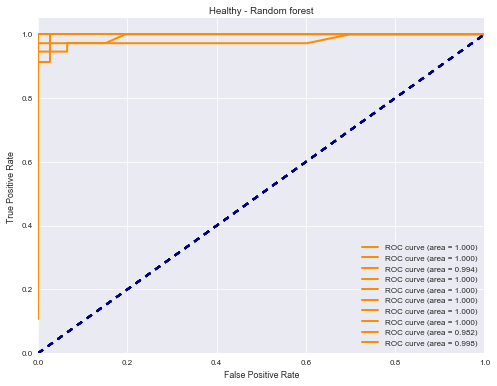

In [45]:
AUC_all = []

plt.figure(figsize=(8,6))

for train_index, test_index in subj.split(X, y, groups):
    
    Xtr, Xte = X[train_index], X[test_index]
    ytr, yte = y[train_index], y[test_index]
    
    #selct features
    #Xtr, Xte = Xtr[:,indmax], Xte[:,indmax]
    
    forest = RandomForestClassifier(n_estimators=50,random_state=10,warm_start=False)    
    forest.fit(Xtr,ytr)
    ypred = forest.predict(Xte)
    yscore = forest.predict_proba(Xte)
    yscore = yscore[:,1]
    acc = np.sum(ypred==yte)/len(ypred)
    #print('Acc = %.4f')%acc
    fpr, tpr, thresholds = metrics.roc_curve(yte, yscore, pos_label=1)
    roc_auc = auc(fpr, tpr)
    print('AUC = %.4f'%roc_auc)    
    AUC_all.append(roc_auc)  
    
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Healthy - Random forest')
plt.legend(loc="lower right")

In [46]:
print('mean AUC = %.3f (+/- %0.3f)')%(np.mean(AUC_all),2*np.std(AUC_all))


mean AUC = 0.997 (+/- 0.011)


In [44]:
print('mean AUC (w feature sel) = %.3f (+/- %0.3f)')%(np.mean(AUC_all),2*np.std(AUC_all))


mean AUC (w feature sel) = 0.996 (+/- 0.015)


## Use jittered data

In [62]:
Healthy = pd.read_csv('./Data/Healthy10.csv',header=None)
Healthy = Healthy.rename(index=int, columns={0:'SubjID',1:'Loc',2:'Subjtype',3:'Falltype'})
Amp = pd.read_csv('./Data/Amp10.csv',header=None)
Amp = Amp.rename(index=int, columns={0:'SubjID',1:'Loc',2:'Subjtype',3:'Falltype'})

In [63]:
Healthy.head(3)

,SubjID,Loc,Subjtype,Falltype,4,5,6,7,8,9,...,1205,1206,1207,1208,1209,1210,1211,1212,1213,1214
0,1,1,1,3,-0.135490,0.023986,-0.22209,-0.034934,0.026296,0.061168,...,1.3975,1.0539,1.371,0.57013,0.042151,0.040205,0.036391,0.082633,0.057698,0.14273
1,1,1,1,3,-0.116930,0.041788,-0.25966,-0.036706,0.028857,0.069082,...,1.0056,-1.0666,1.371,0.59226,0.044890,0.055954,0.064699,0.077030,0.105940,0.13080
2,1,1,1,3,-0.095297,-0.009186,-0.26274,-0.031153,0.019380,0.071339,...,1.5987,2.0886,1.371,0.76639,0.050949,0.099145,0.054502,0.070348,0.107280,0.14524


In [64]:
print ('N falls = %s'%(len(Healthy[Healthy.Falltype < 9])))
print ('N act = %s'%(len(Healthy[Healthy.Falltype == 9]))) #act
print ('Total = %s'%len(Healthy))

N falls = 6337
N act = 315
Total = 6652


In [65]:
print len(Amp[Amp.Falltype < 9])
print len(Amp[Amp.Falltype == 9]) #act
print len(Amp)

1873
307
2180


### CV on Healthy

In [55]:
X = Healthy.iloc[:,4:].as_matrix()
y = Healthy.Falltype.as_matrix()
y[y < 9] = 1
y[y == 9] = 0
groups = Healthy.SubjID.as_matrix()
print groups.shape
print np.unique(groups)
subj = LeaveOneGroupOut()
subj.get_n_splits(X,y,groups)

(6672,)
[ 1  2  3  4  5  6  7  8  9 10]


10

In [56]:
X.shape

(6672, 1211)

AUC = 0.9997
AUC = 0.9904
AUC = 0.9772
AUC = 1.0000
AUC = 1.0000
AUC = 0.9987
AUC = 1.0000
AUC = 1.0000
AUC = 0.9862
AUC = 0.9984


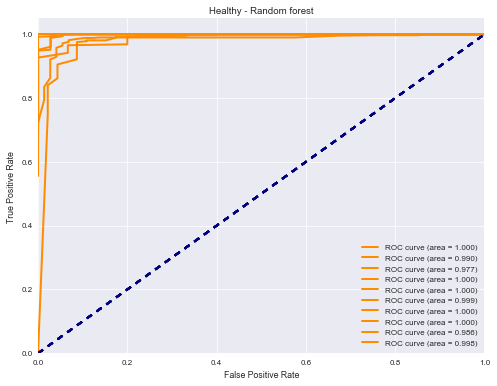

In [58]:
AUC_all = []; ytrue_all = []; ypred_all = []; fpidx = []
tridx = []; teidx = []

plt.figure(figsize=(8,6))

for train_index, test_index in subj.split(X, y, groups):
    
    Xtr, Xte = X[train_index], X[test_index]
    ytr, yte = y[train_index], y[test_index]
    
    tridx.append(train_index)
    teidx.append(test_index)
    #selct features
    #Xtr, Xte = Xtr[:,indmax], Xte[:,indmax]
    
    forest = RandomForestClassifier(n_estimators=50,random_state=10,warm_start=False)    
    forest.fit(Xtr,ytr)
    ypred = forest.predict(Xte)
    ypred_all.append(ypred)
    ytrue_all.append(yte)    
    yscore = forest.predict_proba(Xte)
    yscore = yscore[:,1]
    acc = np.sum(ypred==yte)/len(ypred)
    fpidx.append(np.where((ypred == 1) & (yte == 0)))
    #print('Acc = %.4f')%acc
    
    fpr, tpr, thresholds = metrics.roc_curve(yte, yscore, pos_label=1)
    roc_auc = auc(fpr, tpr)
    print('AUC = %.4f'%roc_auc)    
    AUC_all.append(roc_auc)  
    
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Healthy - Random forest')
plt.legend(loc="lower right")

In [59]:
print('mean AUC = %.3f (+/- %0.3f)')%(np.mean(AUC_all),2*np.std(AUC_all))

mean AUC = 0.995 (+/- 0.015)


In [60]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Non-Fall','Fall'], rotation=45)
    plt.yticks(tick_marks, ['Non-Fall','Fall'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


[[ 10   2]
 [  0 720]]
[[ 0.83333333  0.16666667]
 [ 0.          1.        ]]


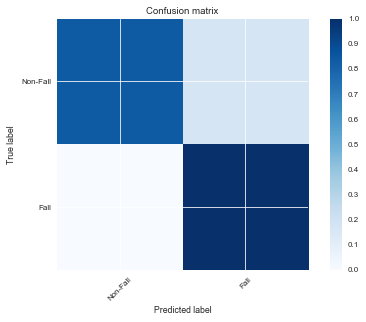

In [61]:
from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(ytrue_all[4],ypred_all[4])
print cmat
totals = cmat.sum(axis=1)
totals = totals.T
totals = np.expand_dims(totals,axis=1)
totals = np.tile(totals,(1,2))
cmat_norm = cmat/totals
print cmat_norm
plot_confusion_matrix(cmat_norm)

In [ ]:
teidx[4].shape

In [ ]:
len(fpidx[4][0])

In [ ]:
fpidx[4][0]

In [ ]:
for idx in fpidx[4]:
    fpidx4 = teidx[4][idx]

In [ ]:
fpidx4

### Amputees
**Note: SubjID 2 does not have activities**

In [ ]:
Amp[Amp.SubjID ==2].Falltype.unique()

In [ ]:
Amp = Amp[Amp.SubjID != 2] #drop subj 2

In [ ]:
X = Amp.iloc[:,4:].as_matrix()
y = Amp.Falltype.as_matrix()
y[y < 9] = 1
y[y == 9] = 0
groups = Amp.SubjID.as_matrix()
print groups.shape
print np.unique(groups)
subj = LeaveOneGroupOut()
subj.get_n_splits(X,y,groups)

In [ ]:
AUC_all = []

plt.figure(figsize=(8,6))

for train_index, test_index in subj.split(X, y, groups):
    
    Xtr, Xte = X[train_index], X[test_index]
    ytr, yte = y[train_index], y[test_index]
    
    #selct features
    #Xtr, Xte = Xtr[:,indmax], Xte[:,indmax]
    
    forest = RandomForestClassifier(n_estimators=50,random_state=10,warm_start=False)    
    forest.fit(Xtr,ytr)
    ypred = forest.predict(Xte)
    yscore = forest.predict_proba(Xte)
    yscore = yscore[:,1]
    acc = np.sum(ypred==yte)/len(ypred)
    #print('Acc = %.4f')%acc
    fpr, tpr, thresholds = metrics.roc_curve(yte, yscore, pos_label=1)
    roc_auc = auc(fpr, tpr)
    print('AUC = %.4f'%roc_auc)    
    AUC_all.append(roc_auc)  
    
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Amputees - Random forest')
plt.legend(loc="lower right")

In [ ]:
# try xgboost
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=1,
 colsample_bytree=1,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=10)

In [ ]:
#LOSO CV
AUC_all = []

plt.figure(figsize=(8,6))

for train_index, test_index in subj.split(X, y, groups):
    
    Xtr, Xte = X[train_index], X[test_index]
    ytr, yte = y[train_index], y[test_index]
    
    #selct features
    Xtr, Xte = Xtr[:,indmax], Xte[:,indmax]

    xgb1.fit(Xtr,ytr)
    ypred = xgb1.predict(Xte)
    yscore = xgb1.predict_proba(Xte)
    yscore = yscore[:,1]
    acc = np.sum(ypred==yte)/len(ypred)
#    print('Acc = %.4f')%acc
    fpr, tpr, thresholds = metrics.roc_curve(yte, yscore, pos_label=1)
    roc_auc = auc(fpr, tpr)
    print('AUC = %.4f'%roc_auc)    
    AUC_all.append(roc_auc)  
    
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Healthy - XGboost forest')
plt.legend(loc="lower right")

In [ ]:
print('mean AUC = %.3f (+/- %0.3f)')%(np.mean(AUC_all),2*np.std(AUC_all))

See here on XGBoost params
http://xgboost.readthedocs.io/en/latest/parameter.html#general-parameters

as well as here
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [ ]:
xgb1.get_params()

In [ ]:
xgb1.fit(Xtr,ytr,eval_metric='auc')

In [ ]:
pred = xgb1.predict(Xte)

In [ ]:
pred_prob = xgb1.predict_proba(Xte)

In [ ]:
pred_prob.shape

In [ ]:
X = Xin.drop(['SubjID','Loc','Subjtype'],axis=1)
X.head(3)

In [ ]:
xgtrain = xgb.DMatrix(X,label='Falltype')
xgtest = xgb.DMatrix(Xte,label='Falltype')

In [ ]:
print xgtrain.num_col()
print xgtrain.num_row()
print xgtest.num_col()
print xgtest.num_row()

Look at the clips

In [ ]:
labels = sio.loadmat('./Data/accHealthy10.mat')

In [ ]:
acc = labels['acc']

In [ ]:
acc.shape

In [ ]:
i

In [ ]:
i = np.random.permutation(fpidx4)
i = i[0]
a = acc[i][0][:,1:]
plt.plot(a)

In [ ]:
np.where(Healthy.Falltype == 0)

In [ ]:
acc